In [1]:
import gymnasium as gym
import torch
import warnings
import numpy as np
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import deque

warnings.filterwarnings("ignore")

In [2]:
class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6, beta_start=0.4, beta_frames=100000):
        self.capacity = capacity
        self.alpha = alpha  # Controls how much prioritization is used (0 = uniform sampling)
        self.beta_start = beta_start  # Initial value of beta for importance sampling
        self.beta_frames = beta_frames  # Number of frames over which beta is annealed to 1
        self.beta = beta_start

        self.buffer = deque(maxlen=capacity)
        self.priorities = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        max_priority = max(self.priorities) if self.buffer else 1.0

        if len(self.buffer) >= self.capacity:
            self.buffer.popleft()
            self.priorities.popleft()

        self.buffer.append((state, action, reward, next_state, done))
        self.priorities.append(max_priority)  # Assign max priority to new experience

    def sample(self, batch_size, frame_idx):
        if len(self.buffer) == 0:
            return [], [], [], [], [], [], []

        self.beta = min(1.0, self.beta_start + frame_idx * (1.0 - self.beta_start) / self.beta_frames)

        priorities = np.array(self.priorities, dtype=np.float32) ** self.alpha
        probs = priorities / priorities.sum()
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)

        samples = [self.buffer[idx] for idx in indices]
        states, actions, rewards, next_states, dones = zip(*samples)

        # Importance sampling weights
        weights = (len(self.buffer) * probs[indices]) ** (-self.beta)
        weights /= weights.max()  # Normalize

        return indices, np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(
            dones), np.array(weights, dtype=np.float32)

    def update_priorities(self, indices, td_errors, epsilon=1e-5):
        for i, idx in enumerate(indices):
            self.priorities[idx] = abs(td_errors[i]) + epsilon


In [3]:
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 64), nn.LeakyReLU(),
            nn.Linear(64, 32), nn.LeakyReLU(),
            nn.Linear(32, action_dim)
        )

    def forward(self, x):
        return self.fc(x)


In [4]:
class DoubleDQNAgent:
    def __init__(self, state_dim, action_dim, gamma=0.99, epsilon=1, lr=1e-3, batch_size=32, target_update=100):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.target_update = target_update
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.policy_net = DQN(state_dim, action_dim).to(self.device)
        self.target_net = DQN(state_dim, action_dim).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.replay_buffer = PrioritizedReplayBuffer(capacity=10000)
        self.steps = 0
        self.updated_count = 0

    def select_action(self, state):
        self.policy_net.eval()
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.policy_net(state_tensor)
        self.policy_net.train()
        tau = max(0.1, self.epsilon)  # Ensure temperature does not reach zero
        probabilities = torch.nn.functional.softmax(q_values / tau, dim=1).cpu().numpy().flatten()
        action = np.random.choice(self.action_dim, p=probabilities)
        return action

    def train(self, frame_idx):
        indices, states, actions, rewards, next_states, dones, weights = self.replay_buffer.sample(self.batch_size,
                                                                                                   frame_idx)
        if len(indices) == 0:
            return

        states = torch.tensor(states, dtype=torch.float32).to(self.device)
        actions = torch.tensor(actions, dtype=torch.long).unsqueeze(1).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(self.device)
        next_states = torch.tensor(next_states, dtype=torch.float32).to(self.device)
        dones = torch.tensor(dones, dtype=torch.float32).to(self.device)
        weights = torch.tensor(weights, dtype=torch.float32).to(self.device)

        q_values = self.policy_net(states).gather(1, actions).squeeze(1)
        next_actions = self.policy_net(next_states).argmax(1, keepdim=True)
        next_q_values = self.target_net(next_states).gather(1, next_actions).squeeze(1)
        expected_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        td_errors = expected_q_values - q_values
        td_errors = td_errors.detach_().cpu().numpy()
        loss = (weights * (q_values - expected_q_values) ** 2).mean()
        self.replay_buffer.update_priorities(indices, td_errors)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.steps += 1
        if self.steps % self.target_update == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
            self.updated_count += 1

    def decay_epsilon(self, min_epsilon=0.01, decay_rate=0.995):
        self.epsilon = max(min_epsilon, self.epsilon * decay_rate)

In [5]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='leaky_relu')


def plot_weight_distribution(model):
    plt.figure(figsize=(12, 4), dpi=400)

    for name, param in model.named_parameters():
        if "weight" in name:
            sns.histplot(param.data.cpu().numpy().flatten(), bins=100, kde=True, label=name)

    plt.title("Weight Distribution of DQN")
    plt.xlabel("Weight Values")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

In [6]:
# 환경 설정
env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

agent = DoubleDQNAgent(state_dim, action_dim)
agent.policy_net.apply(initialize_weights)
agent.target_net.apply(initialize_weights)
episodes = 1000
rewards_log = []
K = 4  # Replay period
frame_idx = 0

# 학습 실행
for episode in tqdm(range(episodes)):
    state, _ = env.reset()
    total_reward = 0

    for t in range(500):
        action = agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated  # 두 종료 신호를 합쳐서 done 처리

        agent.replay_buffer.add(state, action, reward, next_state, done)

        # K 주기마다 학습 수행
        if t % K == 0 and (np.mean(rewards_log[-10:]) < 450):
            agent.train(frame_idx)

        state = next_state
        total_reward += reward
        frame_idx += 1  # 매 스텝마다 증가 (여기가 중요!)
        if done:
            break

    agent.decay_epsilon()
    rewards_log.append(total_reward)

env.close()

100%|██████████| 1000/1000 [05:51<00:00,  2.84it/s]


In [7]:
print(
    f"Total training steps: {frame_idx}, Updated counts: {agent.updated_count}, Epsilon: {agent.epsilon:.2f}, Beta: {agent.replay_buffer.beta:.2f}")

Total training steps: 369832, Updated counts: 227, Epsilon: 0.01, Beta: 0.94


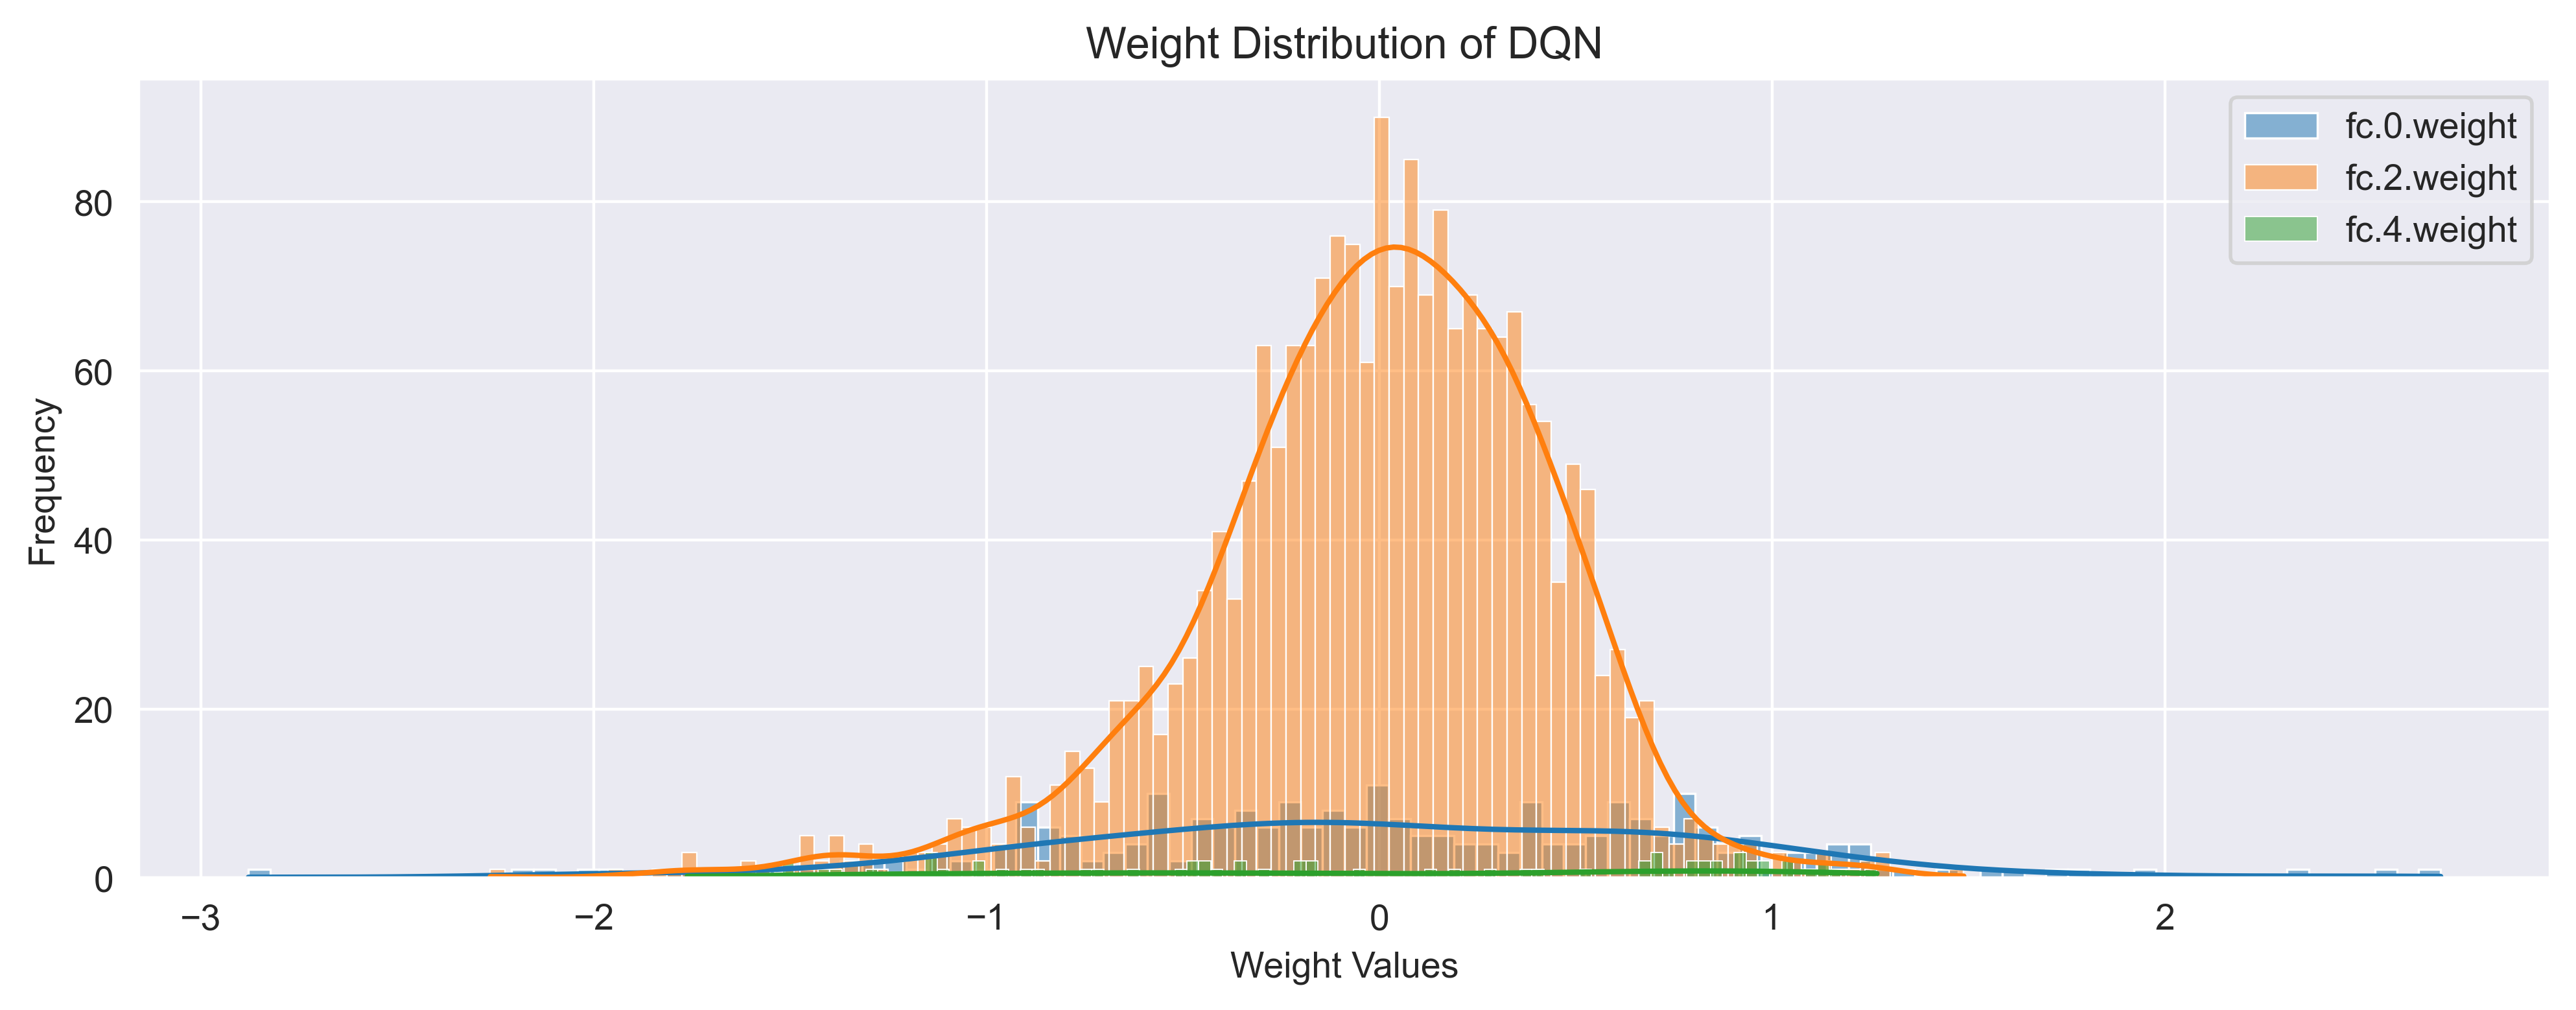

In [8]:
# 현재 policy_net의 가중치 분포 확인
plot_weight_distribution(agent.policy_net)

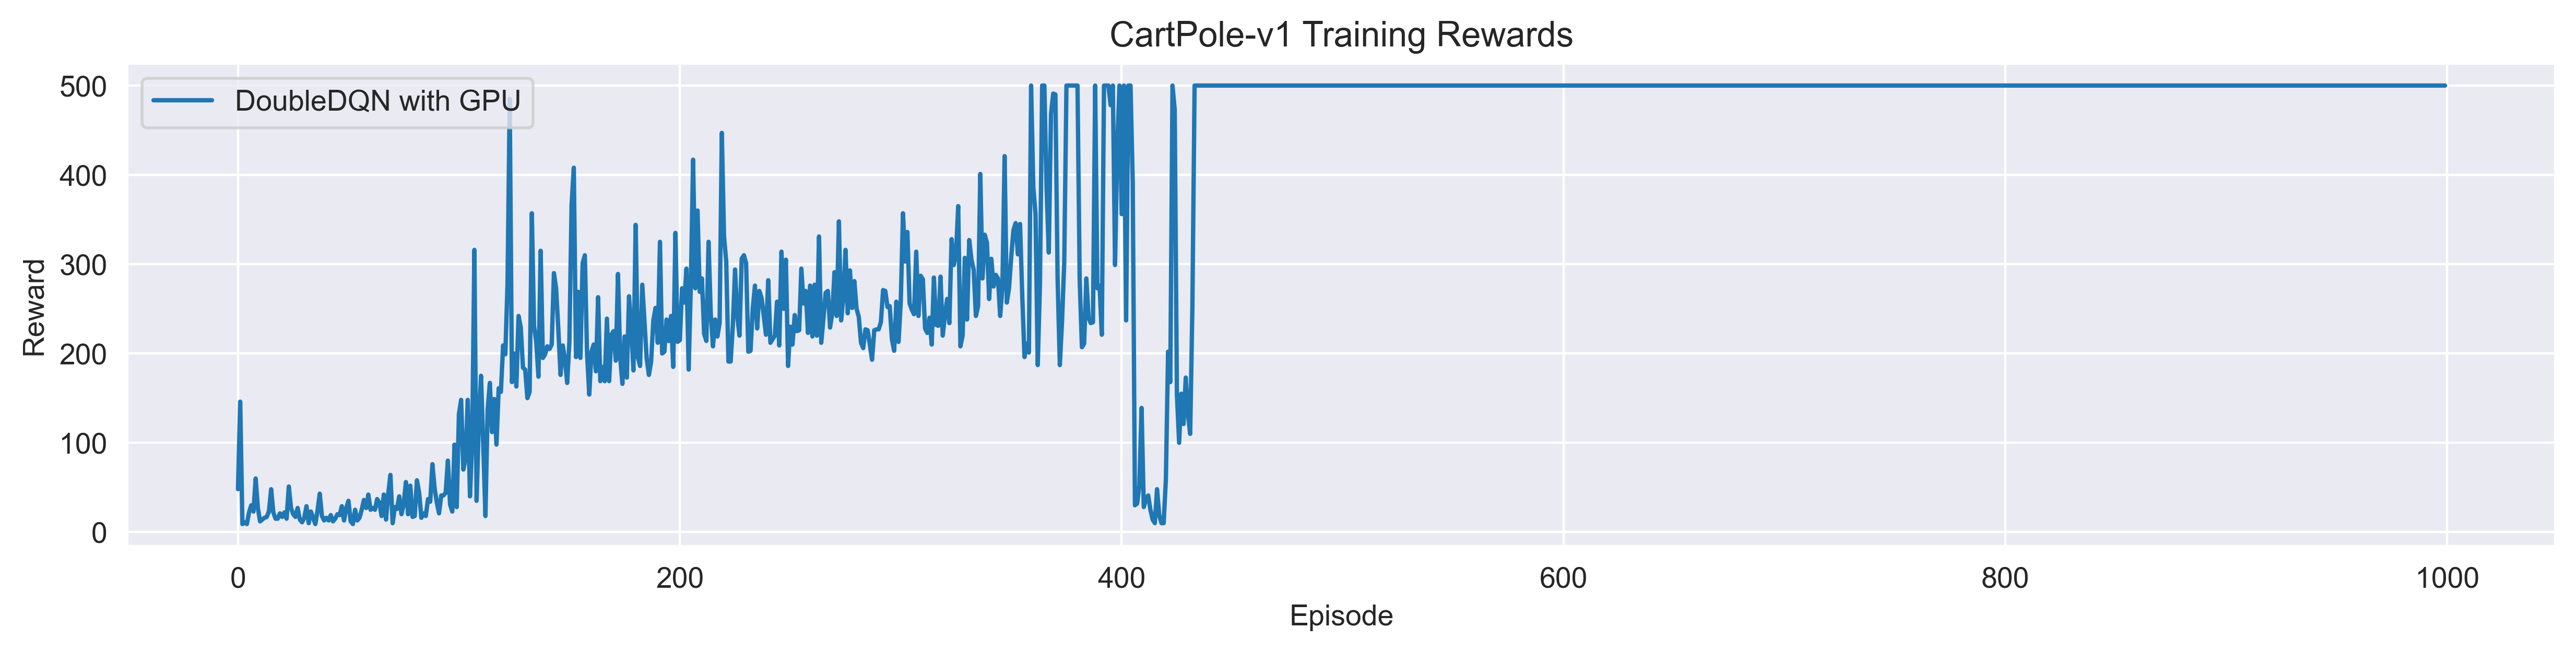

Final epsilon: 0.01
First 10 episode rewards: [48.0, 146.0, 9.0, 11.0, 9.0, 22.0, 30.0, 23.0, 60.0, 27.0]
Last 10 episode rewards: [500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]
Average reward over last 100 episodes: 500.00


In [9]:
# 학습 결과 시각화
plt.figure(figsize=(15, 3), dpi=400)
plt.plot(rewards_log, label="DoubleDQN with GPU")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("CartPole-v1 Training Rewards")
plt.legend(loc="upper left")
plt.show()

print(f"Final epsilon: {agent.epsilon}")
print("First 10 episode rewards:", rewards_log[:10])
print("Last 10 episode rewards:", rewards_log[-10:])
print(f"Average reward over last 100 episodes: {np.mean(rewards_log[-100:]):.2f}")